In [95]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 14, 'figure.figsize': (6, 6)})

# a)

In [96]:
pos = np.loadtxt('particles.dat')

Text(0, 0.5, 'y')

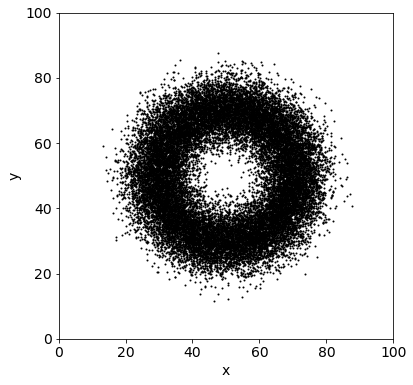

In [97]:
plt.figure(figsize=(6,6))
plt.scatter(pos[:,0], pos[:,1], s=1, color='black')
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.xlabel('x')
plt.ylabel('y')

In [229]:
def cic_assign(pos, M=100):
    grid = np.zeros((M+1, M+1), dtype=float)

    x = pos[:, 0]
    y = pos[:, 1]

    i = np.floor(x).astype(int)
    j = np.floor(y).astype(int)

    dx = x - i - 0.5
    dy = y - j - 0.5

    # weights in x
    wx_l = 1 - np.abs(dx)
    wx_r = np.abs(dx)

    # weights in y
    wy_l = 1 - np.abs(dy)
    wy_r = np.abs(dy)

    i1 = i + np.sign(dx).astype(int)
    j1 = j + np.sign(dy).astype(int)

    def add_to_grid(ii, jj, w):
        m = (ii >= 0) & (ii < M) & (jj >= 0) & (jj < M)
        np.add.at(grid, (jj[m], ii[m]), w[m])

    # Distribute weights to 4 neighbors
    add_to_grid(i,  j,  wx_l * wy_l)
    add_to_grid(i1, j,  wx_r * wy_l)
    add_to_grid(i,  j1, wx_l * wy_r)
    add_to_grid(i1, j1, wx_r * wy_r)

    return grid

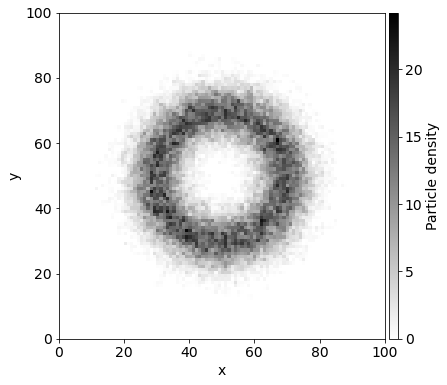

In [230]:
fig, ax = plt.subplots(figsize=(6,6))
density = cic_assign(pos)
c = ax.imshow(density.T, origin='lower', extent=(0, 100, 0, 100), cmap='gray_r')
p = ax.get_position()
cax = fig.add_axes([p.x1 + 0.01, p.y0, 0.02, p.height])
fig.colorbar(c, cax=cax, label='Particle density')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()

# b)

In [ ]:
# Deprecated because it's slow

M = 100
a = 1
e_e = e = 1.602176634e-19 # C
epsilon0 = 8.854187817e-12 # C^2/(N·m^2)

def update_phi(phi, phiprime):
    for i in range(1, M):
        for j in range(1, M):
            phiprime[i,j] = 0.25 * (phi[i+1,j] + phi[i-1,j] + phi[i,j+1] + phi[i,j-1] + a**2 * e_e * density[i-1,j-1]/epsilon0)
    diff = np.max(np.abs(phiprime - phi))
    phi[1:M,1:M] = phiprime[1:M,1:M]
    return diff

In [127]:
M = 100
a = 1
e_e = e = 1.602176634e-19 # C
epsilon0 = 8.854187817e-12 # C^2/(N·m^2)

phi = np.zeros([M+1,M+1], dtype=float)
phiprime = np.empty([M+1,M+1], dtype=float)

for i in range(1000000):
    phiprime[1:-1, 1:-1] = 0.25 * (
        phi[2:, 1:-1] +     # i+1, j
        phi[:-2, 1:-1] +    # i-1, j
        phi[1:-1, 2:] +     # i, j+1
        phi[1:-1, :-2] +    # i, j-1
        a*a * e_e*density[1:-1, 1:-1] / epsilon0
    )
    diff = np.max(np.abs(phiprime[1:-1,1:-1] - phi[1:-1,1:-1]))
    phi[1:-1, 1:-1] = phiprime[1:-1, 1:-1]

    if diff < 1e-10:
        print(f'Converged after {i} iterations.')
        break

Converged after 11852 iterations.


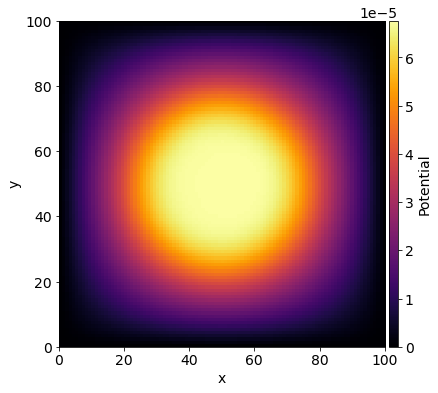

In [128]:
fig, ax = plt.subplots(figsize=(6,6))
c = ax.imshow(phi.T, origin='lower', extent=(0, 100, 0, 100), cmap='inferno')
p = ax.get_position()
cax = fig.add_axes([p.x1 + 0.01, p.y0, 0.02, p.height])
fig.colorbar(c, cax=cax, label='Potential')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()

# c)

In [231]:
# Test gauss-seidel with overrelaxation

max_iters = 10000
M = 100
a = 1
e_e = e = 1.602176634e-19 # C
epsilon0 = 8.854187817e-12 # C^2/(N·m^2)

phi = np.zeros([M+1,M+1], dtype=float)

omega = 1.9

for it in range(max_iters):
    max_diff = 0.0
    for i in range(1, M):
        for j in range(1, M):
            old_val = phi[i, j]
            
            gs_val = 0.25 * (
                phi[i+1,j] + phi[i-1,j] +
                phi[i,j+1] + phi[i,j-1] +
                a*a * e_e * density[i-1,j-1] / epsilon0
            )
            
            new_val = old_val + omega*(gs_val - old_val)
            phi[i,j] = new_val
            
            diff = abs(new_val - old_val)
            if diff > max_diff:
                max_diff = diff

    if max_diff < 1e-10:
        print(f'Converged after {it} iterations.')
        break


Converged after 473 iterations.


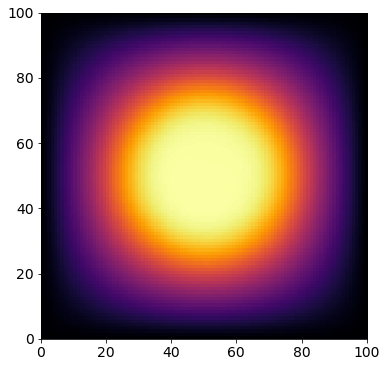

In [232]:
plt.imshow(phi.T, origin='lower', extent=(0, 100, 0, 100), cmap='inferno')

In [132]:
max_diff

9.96363571278947e-11

In [ ]:
# Make the solution a function so that we can use it in the golden ratio search

M = 100
a = 1
e_e = e = 1.602176634e-19 # C
epsilon0 = 8.854187817e-12 # C^2/(N·m^2)

def find_pot(omega, max_iters = 100, tol=1e-10):
    phi = np.zeros([M+1,M+1], dtype=float)

    for it in range(max_iters):
        max_diff = 0.0
        for i in range(1, M):
            for j in range(1, M):
                old_val = phi[i, j]
                
                gs_val = 0.25 * (
                    phi[i+1,j] + phi[i-1,j] +
                    phi[i,j+1] + phi[i,j-1] +
                    a*a * e_e * density[i-1,j-1] / epsilon0
                )
                
                new_val = old_val + omega*(gs_val - old_val)
                phi[i,j] = new_val
                
                diff = abs(new_val - old_val)
                if diff > max_diff:
                    max_diff = diff

        if max_diff < tol:
            print(f'w = {omega}, max_diff = {max_diff}, Converged after {it} iterations.')
            return True, phi, it, max_diff
        
    print(f'w = {omega}, max_diff = {max_diff}, Converged after {it} iterations.')
    return False, phi, max_iters, max_diff

In [ ]:
#golden ratio search that saves history of (a,b) intervals for plot later
def grs(f, a, b, history, tol=1e-3):
    invphi = (np.sqrt(5) - 1) / 2
    c = b - (b - a) * invphi
    d = a + (b - a) * invphi
    fc = f(c)
    fd = f(d)

    while b - a > tol:
        history.append((c, d))
        if fc < fd:  # maximize f
            b = d
            d = c
            fd = fc
            c = b - (b - a) * invphi
            fc = f(c)  # only compute new point
        else:
            a = c
            c = d
            fc = fd
            d = a + (b - a) * invphi
            fd = f(d)  # only compute new point

    return (b + a)/2

In [ ]:
history = []
w = grs(lambda w: find_pot(w, max_iters=500, tol=1e-10)[2], 1.0, 1.99, history)

w = 1.378146351137604, max_diff = 5.184043998303925e-08, Converged after 499 iterations.
w = 1.6118536488623958, max_diff = 3.732143616926671e-08, Converged after 499 iterations.
w = 1.7562927022752082, max_diff = 1.4261462762306127e-08, Converged after 499 iterations.
w = 1.8455609465871876, max_diff = 2.0752013987150163e-09, Converged after 499 iterations.
w = 1.9007317556880206, max_diff = 9.948941051150708e-11, Converged after 469 iterations.
w = 1.9348291908991673, max_diff = 9.889766731789075e-11, Converged after 267 iterations.
w = 1.9559025647888533, max_diff = 9.876439953821229e-11, Converged after 273 iterations.
w = 1.9218051295777066, max_diff = 9.855150972636756e-11, Converged after 353 iterations.
w = 1.9428785034673928, max_diff = 9.666448766987843e-11, Converged after 218 iterations.
w = 1.9478532522206278, max_diff = 9.42553652366092e-11, Converged after 222 iterations.
w = 1.9398039396524023, max_diff = 9.913122560101023e-11, Converged after 217 iterations.
w = 1.9379

In [179]:
history

[(1.378146351137604, 1.6118536488623958),
 (1.6118536488623958, 1.7562927022752082),
 (1.7562927022752082, 1.8455609465871876),
 (1.8455609465871876, 1.9007317556880206),
 (1.9007317556880206, 1.9348291908991673),
 (1.9348291908991673, 1.9559025647888533),
 (1.9218051295777066, 1.9348291908991673),
 (1.9348291908991673, 1.9428785034673928),
 (1.9428785034673928, 1.9478532522206278),
 (1.9398039396524023, 1.9428785034673928),
 (1.9379037547141578, 1.9398039396524023),
 (1.9398039396524023, 1.9409783185291483),
 (1.9409783185291483, 1.941704124590647),
 (1.941704124590647, 1.942152697405894),
 (1.9414268913443953, 1.941704124590647)]

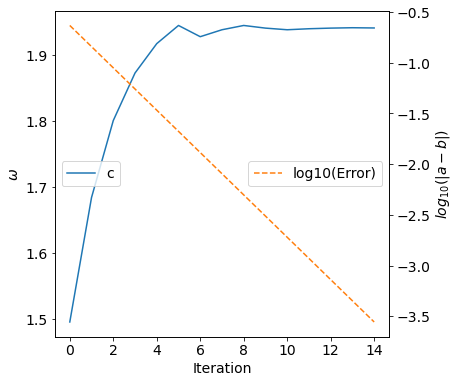

In [200]:
fig, ax = plt.subplots()
ax.plot([(np.abs(h[0] + h[1])/2) for h in history], label='c')
ax2 = ax.twinx()
ax2.plot([np.log10(np.abs(h[0] - h[1])) for h in history], color='C1', linestyle='--', label='log10(Error)')
ax2.set_ylabel(r'$log_{10}(|a-b|)$')
ax.legend(loc='center left')
ax2.legend(loc='center right')
ax.set_xlabel('Iteration')
ax.set_ylabel(r'$\omega$')
ax.set_xticks(range(0, len(history), 2))